# Testing non-linear solvers on the Rosenbrock function

@Author: Ettore Biondi - ebiondi@caltech.edu

## Problem definition

In this notebook we show how to set a user-defined objective function and minimize it using different solvers.
The function understudy is the well-known convex Rosenbrock function. Its analytical form for the 2D case takes the follwing form:
\begin{equation}
\phi(x,y) = (1-x)^2 + 100 (y-x^2)^2,
\end{equation}
in which the unique global minimum is at $x=y=1$. The global minimum is inside a long, narrow, parabolic-shaped flat valley. To find the valley is trivial. To converge to the global minimum, however, is difficult. Hence, this function represents a good testing case for any non-linear optimization scheme.

In [1]:
import numpy as np
import occamypy as o

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'jet',
    'image.aspect'   : 'auto',
    'image.interpolation': None,
    'axes.grid'      : False,
    'figure.figsize' : (10, 6),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : True,
    'font.family'    : 'serif',
    'font.serif'     : 'Latin Modern Roman',
})

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/nas/home/fpicetti/miniconda3/envs/occd/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Let's first define the problem object. Our model vector is going to be $\mathbf{m} = [x \,, \, y]^T$. Since the libary assumes that the objective function is written in terms of some residual vector (i.e., $\phi(\mathbf{r}(\mathbf{m}))$, we will create a vector containing objective function as a single scalar value. 

In [2]:
class Rosenbrock(o.Problem):
    """
    Rosenbrock function inverse problem
    f(x,y) = (1 - x)^2 + 100*(y -x^2)^2
    m = [x y]'
    res = objective function value
    """

    def __init__(self, x_initial, y_initial, minBound=None, maxBound=None):
        """Constructor of linear problem"""
        #Setting the bounds (if any)
        super(Rosenbrock, self).__init__(model=o.VectorNumpy(np.array((x_initial, y_initial))),
                                         data=o.VectorNumpy((1,)),
                                         minBound=minBound, maxBound=maxBound)
        
        #Gradient vector
        self.grad = self.pert_model.clone()
        
        #Setting default variables
        self.setDefaults()
        self.linear = False
        return

    def obj_func(self, model):
        m = model.getNdArray()
        obj = self.res.arr[0]
        return obj

    def res_func(self, model):
        m = model.getNdArray()
        self.res[0] = (1.0 - m[0])*(1.0 - m[0]) + 100.0 * (m[1] - m[0]*m[0]) * (m[1] - m[0]*m[0])
        return self.res

    def grad_func(self, model, residual):
        m = model.getNdArray()
        self.grad[0] = - 2.0 * (1.0 - m[0]) - 400.0 * m[0] * (m[1] - m[0]*m[0])
        self.grad[1] = 200.0 * (m[1] - m[0]*m[0])
        return self.grad

    def pert_res_func(self, model, pert_model):
        m = model.getNdArray()
        dm = pert_model.getNdArray()
        self.pert_res.arr[0] = (- 2.0 * (1.0 - m[0]) - 400.0 * m[0] * (m[1] - m[0]*m[0]))* dm[0] + (200.0 * (m[1] - m[0]*m[0])) * dm[1]
        return self.pert_res

### Instantiation of the inverse problem and of the various solvers

In [3]:
# Starting point for all the optimization problem
x_init = -1.0
y_init = -1.0
# Testing solver on Rosenbrock function
Ros_prob = Rosenbrock(x_init, y_init)

Before running any inversion, let's compute the objective function for different values of $x$ and $y$. This step will be useful when we want to plot the optimization path taken by the various tested algorithms.

In [4]:
#Computing the objective function for plotting
x_samples = np.linspace(-1.5,  1.5, 1000)
y_samples = np.linspace(   3, -1.5, 1000)

obj_ros = o.VectorNumpy((x_samples.size, y_samples.size))
model_test = o.VectorNumpy((2,))

for ix, x_value in enumerate(x_samples):
    for iy, y_value in enumerate(y_samples):
        model_test[0]  = x_value
        model_test[1]  = y_value
        obj_ros[ix, iy] = Ros_prob.get_obj(model_test)

First we test a non-linear conjugate-gradient method in which a parabolic stepper with three-point interpolation is used. 

In [5]:
niter = 1000
Stop  = o.BasicStopper(niter=niter, tolr=1e-32, tolg=1e-32)
NLCGsolver = o.NLCG(Stop)
Ros_prob = Rosenbrock(x_init, y_init) #Resetting the problem
NLCGsolver.setDefaults(save_obj=True, save_model=True)
NLCGsolver.run(Ros_prob,verbose=True)

# Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(NLCGsolver.model)):
    x_smpld.append(NLCGsolver.model[i][0])
    y_smpld.append(NLCGsolver.model[i][1])

##########################################################################################
            Nonlinear CG Solver 
    Restart folder: /tmp/restart_2022-04-22T01-49-05.870101/
    Conjugate method used: FR
##########################################################################################

iter = 0000, obj = 4.04e+02, rnorm = 4.04e+02, gnorm = 8.98e+02, feval = 00001, geval = 0001
iter = 0001, obj = 4.01e+01, rnorm = 4.01e+01, gnorm = 1.33e+02, feval = 00004, geval = 0002
iter = 0002, obj = 1.75e+00, rnorm = 1.75e+00, gnorm = 1.87e+01, feval = 00007, geval = 0003
iter = 0003, obj = 8.70e-01, rnorm = 8.70e-01, gnorm = 1.88e+00, feval = 00010, geval = 0004
iter = 0004, obj = 8.40e-01, rnorm = 8.40e-01, gnorm = 1.81e+00, feval = 00013, geval = 0005
iter = 0005, obj = 7.38e-01, rnorm = 7.38e-01, gnorm = 2.27e+00, feval = 00016, geval = 0006
iter = 0006, obj = 5.41e-01, rnorm = 5.41e-01, gnorm = 4.40e+00, feval = 00019, geval = 0007
iter = 0007, obj = 4.83e-01, rnorm = 4.83e

Let's plot the optimization path taken by the algorithm, which converged to the global minimum in 199 iterations using a parabolic stepper.

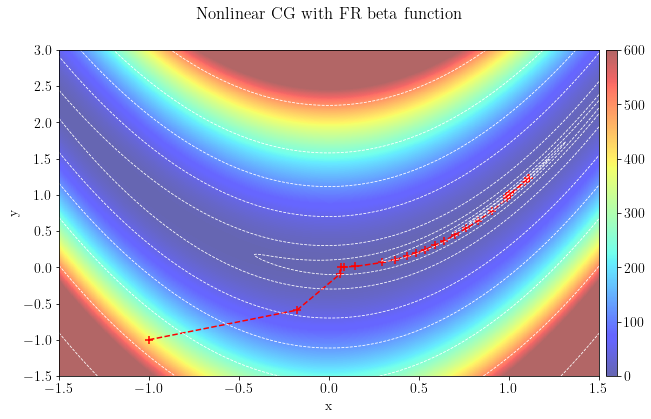

In [6]:
fig, ax = plt.subplots()

ax.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
ax.plot(x_smpld, y_smpld, "--", color='red')

im = ax.imshow(obj_ros.plot().T, alpha=0.6, clim=(0,600), extent=[1.5,-1.5,-1.5,3.0])
ax.set_xlabel("x"), ax.set_ylabel("y")
ax.invert_xaxis()

cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white", linewidths=(0.8,), linestyles='--')
divider = make_axes_locatable(ax)
plt.colorbar(im, cax=divider.append_axes("right", size="2%", pad=0.1))
plt.suptitle(r"Nonlinear CG with FR beta function")
plt.show()

For the second test, we will test the steppest-descent approach using the same stepper.

In [7]:
NLSDsolver = o.NLCG(Stop, beta_type="SD")
Ros_prob = Rosenbrock(x_init, y_init)
NLSDsolver.setDefaults(save_obj=True, save_model=True)
NLSDsolver.run(Ros_prob, verbose=True)

# Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(NLSDsolver.model)):
    x_smpld.append(NLSDsolver.model[i][0])
    y_smpld.append(NLSDsolver.model[i][1])

##########################################################################################
            Nonlinear SD Solver 
    Restart folder: /tmp/restart_2022-04-22T01-49-07.409475/
##########################################################################################

iter = 0000, obj = 4.04e+02, rnorm = 4.04e+02, gnorm = 8.98e+02, feval = 00001, geval = 0001
iter = 0001, obj = 2.06e+01, rnorm = 2.06e+01, gnorm = 9.40e+01, feval = 00004, geval = 0002
iter = 0002, obj = 9.73e-01, rnorm = 9.73e-01, gnorm = 5.19e+00, feval = 00007, geval = 0003
iter = 0003, obj = 8.96e-01, rnorm = 8.96e-01, gnorm = 2.04e+00, feval = 00010, geval = 0004
iter = 0004, obj = 8.44e-01, rnorm = 8.44e-01, gnorm = 4.55e+00, feval = 00013, geval = 0005
iter = 0005, obj = 7.86e-01, rnorm = 7.86e-01, gnorm = 1.84e+00, feval = 00016, geval = 0006
iter = 0006, obj = 7.40e-01, rnorm = 7.40e-01, gnorm = 4.75e+00, feval = 00019, geval = 0007
iter = 0007, obj = 6.83e-01, rnorm = 6.83e-01, gnorm = 1.65e+00, feval =

iter = 0218, obj = 7.54e-02, rnorm = 7.54e-02, gnorm = 5.85e-01, feval = 00658, geval = 0219
iter = 0219, obj = 7.50e-02, rnorm = 7.50e-02, gnorm = 3.66e-01, feval = 00661, geval = 0220
iter = 0220, obj = 7.46e-02, rnorm = 7.46e-02, gnorm = 5.81e-01, feval = 00664, geval = 0221
iter = 0221, obj = 7.42e-02, rnorm = 7.42e-02, gnorm = 3.64e-01, feval = 00667, geval = 0222
iter = 0222, obj = 7.39e-02, rnorm = 7.39e-02, gnorm = 5.77e-01, feval = 00670, geval = 0223
iter = 0223, obj = 7.35e-02, rnorm = 7.35e-02, gnorm = 3.62e-01, feval = 00673, geval = 0224
iter = 0224, obj = 7.31e-02, rnorm = 7.31e-02, gnorm = 5.73e-01, feval = 00676, geval = 0225
iter = 0225, obj = 7.28e-02, rnorm = 7.28e-02, gnorm = 3.59e-01, feval = 00679, geval = 0226
iter = 0226, obj = 7.24e-02, rnorm = 7.24e-02, gnorm = 5.70e-01, feval = 00682, geval = 0227
iter = 0227, obj = 7.20e-02, rnorm = 7.20e-02, gnorm = 3.57e-01, feval = 00685, geval = 0228
iter = 0228, obj = 7.17e-02, rnorm = 7.17e-02, gnorm = 5.66e-01, feval

iter = 0421, obj = 3.22e-02, rnorm = 3.22e-02, gnorm = 2.20e-01, feval = 01267, geval = 0422
iter = 0422, obj = 3.21e-02, rnorm = 3.21e-02, gnorm = 3.49e-01, feval = 01270, geval = 0423
iter = 0423, obj = 3.20e-02, rnorm = 3.20e-02, gnorm = 2.20e-01, feval = 01273, geval = 0424
iter = 0424, obj = 3.19e-02, rnorm = 3.19e-02, gnorm = 3.47e-01, feval = 01276, geval = 0425
iter = 0425, obj = 3.17e-02, rnorm = 3.17e-02, gnorm = 2.19e-01, feval = 01279, geval = 0426
iter = 0426, obj = 3.16e-02, rnorm = 3.16e-02, gnorm = 3.46e-01, feval = 01282, geval = 0427
iter = 0427, obj = 3.15e-02, rnorm = 3.15e-02, gnorm = 2.18e-01, feval = 01285, geval = 0428
iter = 0428, obj = 3.14e-02, rnorm = 3.14e-02, gnorm = 3.44e-01, feval = 01288, geval = 0429
iter = 0429, obj = 3.13e-02, rnorm = 3.13e-02, gnorm = 2.17e-01, feval = 01291, geval = 0430
iter = 0430, obj = 3.12e-02, rnorm = 3.12e-02, gnorm = 3.43e-01, feval = 01294, geval = 0431
iter = 0431, obj = 3.11e-02, rnorm = 3.11e-02, gnorm = 2.16e-01, feval

iter = 0762, obj = 1.12e-02, rnorm = 1.12e-02, gnorm = 1.93e-01, feval = 02290, geval = 0763
iter = 0763, obj = 1.11e-02, rnorm = 1.11e-02, gnorm = 1.22e-01, feval = 02293, geval = 0764
iter = 0764, obj = 1.11e-02, rnorm = 1.11e-02, gnorm = 1.92e-01, feval = 02296, geval = 0765
iter = 0765, obj = 1.11e-02, rnorm = 1.11e-02, gnorm = 1.21e-01, feval = 02299, geval = 0766
iter = 0766, obj = 1.11e-02, rnorm = 1.11e-02, gnorm = 1.92e-01, feval = 02302, geval = 0767
iter = 0767, obj = 1.10e-02, rnorm = 1.10e-02, gnorm = 1.21e-01, feval = 02305, geval = 0768
iter = 0768, obj = 1.10e-02, rnorm = 1.10e-02, gnorm = 1.91e-01, feval = 02308, geval = 0769
iter = 0769, obj = 1.10e-02, rnorm = 1.10e-02, gnorm = 1.21e-01, feval = 02311, geval = 0770
iter = 0770, obj = 1.09e-02, rnorm = 1.09e-02, gnorm = 1.90e-01, feval = 02314, geval = 0771
iter = 0771, obj = 1.09e-02, rnorm = 1.09e-02, gnorm = 1.20e-01, feval = 02317, geval = 0772
iter = 0772, obj = 1.09e-02, rnorm = 1.09e-02, gnorm = 1.90e-01, feval

Let's again plot the optimization path. In this case, the algorithm finds only falls close to the vicinity of the global minimum but does not reach even after 1000 iteration. In the figure below, we can see that the algorithm is sampling most of the objective function within the parabolic valley.

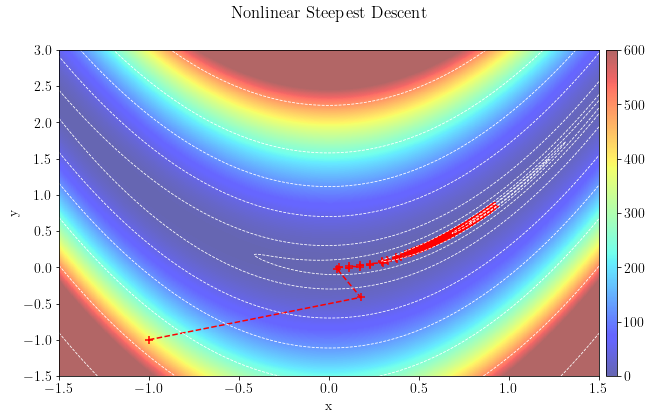

In [8]:
fig, ax = plt.subplots()

ax.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
ax.plot(x_smpld, y_smpld, "--", color='red')

im = ax.imshow(obj_ros.plot().T, alpha=0.6, clim=(0,600), extent=[1.5,-1.5,-1.5,3.0])
ax.set_xlabel("x"), ax.set_ylabel("y")
ax.invert_xaxis()

cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white", linewidths=(0.8,), linestyles='--')
divider = make_axes_locatable(ax)
plt.colorbar(im, cax=divider.append_axes("right", size="2%", pad=0.1))
plt.suptitle(r"Nonlinear Steepest Descent")

plt.show()

In the third test, let's apply the BFGS algorithm to find the function's global minimum.

In [9]:
ParabStep = o.ParabolicStep()
BFGSsolver = o.LBFGS(Stop, stepper=ParabStep)
Ros_prob = Rosenbrock(x_init, y_init)
BFGSsolver.setDefaults(save_obj=True, save_model=True)
BFGSsolver.run(Ros_prob, verbose=True)

# Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(BFGSsolver.model)):
    x_smpld.append(BFGSsolver.model[i][0])
    y_smpld.append(BFGSsolver.model[i][1])

##########################################################################################
            BFGS Solver 
    Restart folder: /tmp/restart_2022-04-22T01-49-08.932818/
##########################################################################################

iter = 0000, obj = 4.04e+02, rnorm = 4.04e+02, gnorm = 8.98e+02, feval = 00001, geval = 0001
iter = 0001, obj = 4.01e+01, rnorm = 4.01e+01, gnorm = 1.33e+02, feval = 00004, geval = 0002
iter = 0002, obj = 1.47e+00, rnorm = 1.47e+00, gnorm = 1.50e+01, feval = 00007, geval = 0003
iter = 0003, obj = 8.58e-01, rnorm = 8.58e-01, gnorm = 2.09e+00, feval = 00010, geval = 0004
iter = 0004, obj = 8.50e-01, rnorm = 8.50e-01, gnorm = 2.01e+00, feval = 00013, geval = 0005
iter = 0005, obj = 7.40e-01, rnorm = 7.40e-01, gnorm = 8.34e+00, feval = 00016, geval = 0006
iter = 0006, obj = 6.72e-01, rnorm = 6.72e-01, gnorm = 2.65e+00, feval = 00019, geval = 0007
iter = 0007, obj = 5.62e-01, rnorm = 5.62e-01, gnorm = 2.40e+00, feval = 00022, 

The algorithm has precisely reached the global minimum in 24 iterations. We can clearly see that it is able to find an approximation of the local curvature of the objective function. In fact, it needs to sample very few points within the parabolic-shaped valley. 

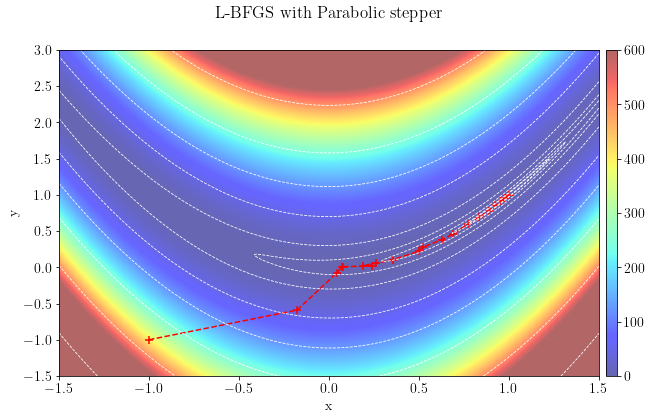

In [10]:
fig, ax = plt.subplots()

ax.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
ax.plot(x_smpld, y_smpld, "--", color='red')

im = ax.imshow(obj_ros.plot().T, alpha=0.6, clim=(0,600), extent=[1.5,-1.5,-1.5,3.0])
ax.set_xlabel("x"), ax.set_ylabel("y")
ax.invert_xaxis()

cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white", linewidths=(0.8,), linestyles='--')
divider = make_axes_locatable(ax)
plt.colorbar(im, cax=divider.append_axes("right", size="2%", pad=0.1))
plt.suptitle("L-BFGS with Parabolic stepper")
plt.show()

Let's try to solve the same problem using the Strong-Wolfe stepper described by Nocedal and Wright (1999) in the Algorithm 3.2 on page 59.

In [11]:
WolfeStep = o.StrongWolfe(alpha=0.0) #We now use a stepper that satisfies the strong Wolfe conditions
BFGSsolver = o.LBFGS(Stop, stepper=WolfeStep)
Ros_prob = Rosenbrock(x_init, y_init) #Resetting the problem
BFGSsolver.setDefaults(save_obj=True, save_model=True)
BFGSsolver.run(Ros_prob, verbose=True)

# Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(BFGSsolver.model)):
    x_smpld.append(BFGSsolver.model[i][0])
    y_smpld.append(BFGSsolver.model[i][1])

##########################################################################################
            BFGS Solver 
    Restart folder: /tmp/restart_2022-04-22T01-49-09.683188/
##########################################################################################

iter = 0000, obj = 4.04e+02, rnorm = 4.04e+02, gnorm = 8.98e+02, feval = 00001, geval = 0001
iter = 0001, obj = 1.36e+02, rnorm = 1.36e+02, gnorm = 3.63e+02, feval = 00002, geval = 0002
iter = 0002, obj = 5.54e+01, rnorm = 5.54e+01, gnorm = 1.81e+02, feval = 00003, geval = 0003
iter = 0003, obj = 1.77e+01, rnorm = 1.77e+01, gnorm = 8.53e+01, feval = 00004, geval = 0004
iter = 0004, obj = 4.91e+00, rnorm = 4.91e+00, gnorm = 3.96e+01, feval = 00005, geval = 0005
iter = 0005, obj = 1.35e+00, rnorm = 1.35e+00, gnorm = 1.43e+01, feval = 00006, geval = 0006
iter = 0006, obj = 7.80e-01, rnorm = 7.80e-01, gnorm = 2.83e+00, feval = 00007, geval = 0007
iter = 0007, obj = 7.39e-01, rnorm = 7.39e-01, gnorm = 2.13e+00, feval = 00008, 

The BFGS algorithm combined with this specific stepper reached the objective function's minimum in 35 iterations with 50 and 45 function and gradient evaluations, respectively.

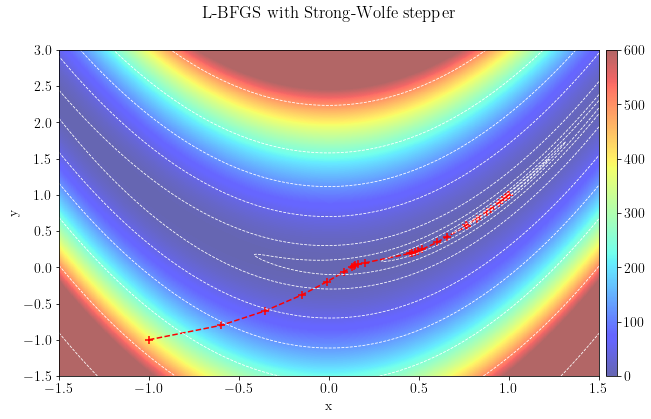

In [12]:
fig, ax = plt.subplots()

ax.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
ax.plot(x_smpld, y_smpld, "--", color='red')

im = ax.imshow(obj_ros.plot().T, alpha=0.6, clim=(0,600), extent=[1.5,-1.5,-1.5,3.0])
ax.set_xlabel("x"), ax.set_ylabel("y")
ax.invert_xaxis()

cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white", linewidths=(0.8,), linestyles='--')
divider = make_axes_locatable(ax)
plt.colorbar(im, cax=divider.append_axes("right", size="2%", pad=0.1))
plt.suptitle("L-BFGS with Strong-Wolfe stepper")
plt.show()

Finally, let's test again the BFGS method but this time employing the line-search algorithm proposed by More and Thuente (1994). Their line-search method uses a backeting approach in which the strong Wolfe conditions are verified for the tested point. In this case, if these conditons are met, then the method was successful.

In [13]:
BFGSsolver = o.LBFGS(Stop)
Ros_prob = Rosenbrock(x_init, y_init)
BFGSsolver.setDefaults(save_obj=True, save_model=True)
BFGSsolver.run(Ros_prob, verbose=True)

# Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(BFGSsolver.model)):
    x_smpld.append(BFGSsolver.model[i][0])
    y_smpld.append(BFGSsolver.model[i][1])

##########################################################################################
            BFGS Solver 
    Restart folder: /tmp/restart_2022-04-22T01-49-10.348843/
##########################################################################################

iter = 0000, obj = 4.04e+02, rnorm = 4.04e+02, gnorm = 8.98e+02, feval = 00001, geval = 0001
iter = 0001, obj = 1.36e+02, rnorm = 1.36e+02, gnorm = 3.63e+02, feval = 00002, geval = 0002
iter = 0002, obj = 5.54e+01, rnorm = 5.54e+01, gnorm = 1.81e+02, feval = 00003, geval = 0003
iter = 0003, obj = 1.77e+01, rnorm = 1.77e+01, gnorm = 8.53e+01, feval = 00004, geval = 0004
iter = 0004, obj = 4.91e+00, rnorm = 4.91e+00, gnorm = 3.96e+01, feval = 00005, geval = 0005
iter = 0005, obj = 1.35e+00, rnorm = 1.35e+00, gnorm = 1.43e+01, feval = 00006, geval = 0006
iter = 0006, obj = 7.80e-01, rnorm = 7.80e-01, gnorm = 2.83e+00, feval = 00007, geval = 0007
iter = 0007, obj = 7.39e-01, rnorm = 7.39e-01, gnorm = 2.13e+00, feval = 00008, 

We can see that the algorithm has reached the global minimum in 36 iterations.
However, since we employed a different stepping method, in which no parabolic interpolation is used during the optimization, the algorithm had to perfom only 41 objective function evaluations as opposed to 73 necessary by the BFGS method when the parabolic stepper was the line-search algorithm of choice.

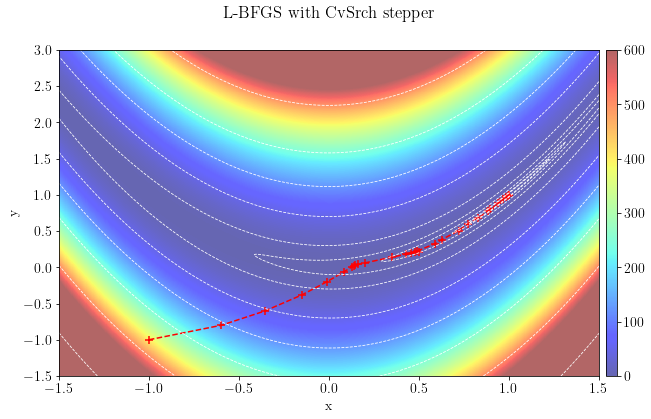

In [14]:
fig, ax = plt.subplots()

ax.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
ax.plot(x_smpld, y_smpld, "--", color='red')

im = ax.imshow(obj_ros.plot().T, alpha=0.6, clim=(0,600), extent=[1.5,-1.5,-1.5,3.0])
ax.set_xlabel("x"), ax.set_ylabel("y")
ax.invert_xaxis()

cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white", linewidths=(0.8,), linestyles='--')
divider = make_axes_locatable(ax)
plt.colorbar(im, cax=divider.append_axes("right", size="2%", pad=0.1))
plt.suptitle("L-BFGS with CvSrch stepper")

plt.show()

### Constrained non-linear optimization 

We now try to solve the save non-linear problem but we impose maximum and minimum boundary conditions as follows:
\begin{equation}
\phi(x,y) = (1-x)^2 + 100 (y-x^2)^2,\\
\text{s.t.} \; x_l \leq x \leq x_m \; \text{and} \; y_l \leq y \leq y_m 
\end{equation}
where $x_l$, $y_l$, $x_m$, and $y_m$ represent the minimum and maximum allowed values for each optimization variable, respectively. Let's first define a problem object with two bound vectors having the inequality conditions shown in the previous equations. To solve such problem, we employ the L-BFGS-B algorithm proposed by Byrd et al. (1995). Let's try with some bounds that contains the global minimum of the objective function.

In [15]:
# Lower and upper bounds and associtated vectors
xl, yl = -1.2, -1.2
xu, yu = 1.2, 2.0
minBound = o.VectorNumpy(np.array((xl, yl)))
maxBound = o.VectorNumpy(np.array((xu, yu)))

Stop  = o.BasicStopper(niter=1000, tolg_proj=1e-32)
BFGSBsolver = o.LBFGSB(Stop, m_steps=10)
Ros_prob = Rosenbrock(x_init, y_init, minBound, maxBound)
BFGSBsolver.setDefaults(save_obj=True, save_model=True)
BFGSBsolver.run(Ros_prob,verbose=True)

# Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(BFGSBsolver.model)):
    x_smpld.append(BFGSBsolver.model[i][0])
    y_smpld.append(BFGSBsolver.model[i][1])

# Setting bounds for plotting
bounds_points_x = np.array([minBound[0],minBound[0],maxBound[0],maxBound[0],minBound[0]])
bounds_points_y = np.array([minBound[1],maxBound[1],maxBound[1],minBound[1],minBound[1]])


##########################################################################################
            L-BFGS-B Solver 
    Max steps to invert the Hessian: 10 
    Restart folder: /tmp/restart_2022-04-22T01-49-11.102678/
##########################################################################################

iter = 0000, obj = 4.04e+02, rnorm = 4.04e+02, gnorm = 8.98e+02, feval = 00001, geval = 0001
iter = 0001, obj = 1.50e+01, rnorm = 1.50e+01, gnorm = 9.49e+01, feval = 00002, geval = 0002
iter = 0002, obj = 4.26e+00, rnorm = 4.26e+00, gnorm = 3.98e+01, feval = 00003, geval = 0003
iter = 0003, obj = 1.74e+00, rnorm = 1.74e+00, gnorm = 3.77e+00, feval = 00004, geval = 0004
iter = 0004, obj = 1.72e+00, rnorm = 1.72e+00, gnorm = 2.38e+00, feval = 00005, geval = 0005
iter = 0005, obj = 1.67e+00, rnorm = 1.67e+00, gnorm = 2.60e+00, feval = 00006, geval = 0006
iter = 0006, obj = 1.07e+00, rnorm = 1.07e+00, gnorm = 6.68e+00, feval = 00015, geval = 0012
iter = 0007, obj = 1.04e+00, rnorm 

The method is able to reach the global minimum since it is contianed within the provided bounds (plotted with white dashed segments). 

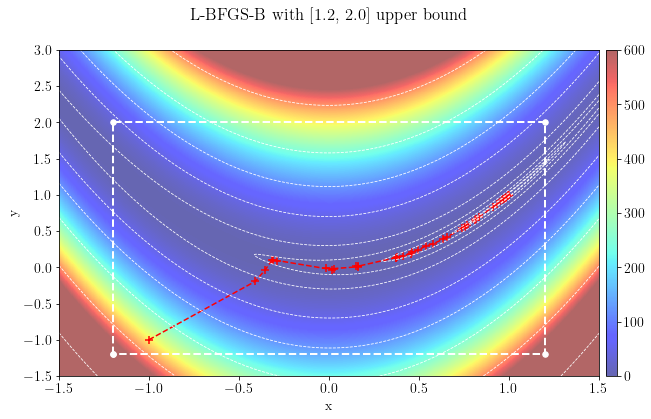

In [16]:
fig, ax = plt.subplots()

ax.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
ax.plot(x_smpld, y_smpld, "--", color='red')

ax.scatter(bounds_points_x, bounds_points_y, marker="o", color='w', s=30)
ax.plot(bounds_points_x, bounds_points_y, "--", color='w', linewidth=2)

im = ax.imshow(obj_ros.plot().T, alpha=0.6, clim=(0,600), extent=[1.5,-1.5,-1.5,3.0])
ax.set_xlabel("x"), ax.set_ylabel("y")
ax.invert_xaxis()

cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white", linewidths=(0.8,), linestyles='--')
divider = make_axes_locatable(ax)
plt.colorbar(im, cax=divider.append_axes("right", size="2%", pad=0.1))
plt.suptitle(r"L-BFGS-B with %s upper bound" % maxBound[:].tolist())
plt.show()

Let's now try to reduce the upper bounds and see where the method stops.

In [17]:
# Lower and upper bounds and associtated vectors
xl, yl = -1.2, -1.2
xu, yu = 0.5, 1.0
minBound = o.VectorNumpy(np.array((xl, yl)))
maxBound = o.VectorNumpy(np.array((xu, yu)))

Stop  = o.BasicStopper(niter=1000, tolg_proj=1e-32)
BFGSBsolver = o.LBFGSB(Stop, m_steps=10)
Ros_prob = Rosenbrock(x_init, y_init, minBound, maxBound)
BFGSBsolver.setDefaults(save_obj=True, save_model=True)
BFGSBsolver.run(Ros_prob,verbose=True)

# Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(BFGSBsolver.model)):
    x_smpld.append(BFGSBsolver.model[i][0])
    y_smpld.append(BFGSBsolver.model[i][1])

# Setting bounds for plotting
bounds_points_x = np.array([minBound[0],minBound[0],maxBound[0],maxBound[0],minBound[0]])
bounds_points_y = np.array([minBound[1],maxBound[1],maxBound[1],minBound[1],minBound[1]])


##########################################################################################
            L-BFGS-B Solver 
    Max steps to invert the Hessian: 10 
    Restart folder: /tmp/restart_2022-04-22T01-49-11.781368/
##########################################################################################

iter = 0000, obj = 4.04e+02, rnorm = 4.04e+02, gnorm = 8.98e+02, feval = 00001, geval = 0001
iter = 0001, obj = 1.49e+01, rnorm = 1.49e+01, gnorm = 9.40e+01, feval = 00002, geval = 0002
iter = 0002, obj = 4.33e+00, rnorm = 4.33e+00, gnorm = 4.02e+01, feval = 00003, geval = 0003
iter = 0003, obj = 1.72e+00, rnorm = 1.72e+00, gnorm = 3.79e+00, feval = 00004, geval = 0004
iter = 0004, obj = 1.69e+00, rnorm = 1.69e+00, gnorm = 2.37e+00, feval = 00005, geval = 0005
iter = 0005, obj = 1.64e+00, rnorm = 1.64e+00, gnorm = 2.59e+00, feval = 00006, geval = 0006
iter = 0006, obj = 1.05e+00, rnorm = 1.05e+00, gnorm = 5.78e+00, feval = 00013, geval = 0011
iter = 0007, obj = 1.02e+00, rnorm 

The algorithm reaches the closest feasible minimum point as we can see from the plot below. This point is indeed positioned at on of the boundary.

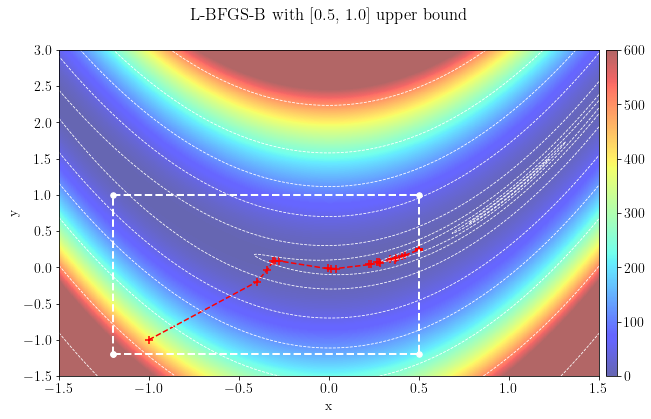

In [18]:
fig, ax = plt.subplots()

ax.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
ax.plot(x_smpld, y_smpld, "--", color='red')

ax.scatter(bounds_points_x, bounds_points_y, marker="o", color='w', s=30)
ax.plot(bounds_points_x, bounds_points_y, "--", color='w', linewidth=2)

im = ax.imshow(obj_ros.plot().T, alpha=0.6, clim=(0,600), extent=[1.5,-1.5,-1.5,3.0])
ax.set_xlabel("x"), ax.set_ylabel("y")
ax.invert_xaxis()

cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white", linewidths=(0.8,), linestyles='--')
divider = make_axes_locatable(ax)
plt.colorbar(im, cax=divider.append_axes("right", size="2%", pad=0.1))
plt.suptitle(r"L-BFGS-B with %s upper bound" % maxBound[:].tolist())
plt.show()

In [19]:
# Lower and upper bounds and associtated vectors
xl, yl = -1.2, -1.2
xu, yu = 0., 0.
minBound = o.VectorNumpy(np.array((xl, yl)))
maxBound = o.VectorNumpy(np.array((xu, yu)))

Stop  = o.BasicStopper(niter=1000, tolg_proj=1e-32)
BFGSBsolver = o.LBFGSB(Stop, m_steps=10)
Ros_prob = Rosenbrock(x_init, y_init, minBound, maxBound) #Resetting the problem
BFGSBsolver.setDefaults(save_obj=True, save_model=True)
BFGSBsolver.run(Ros_prob,verbose=True)

# Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(BFGSBsolver.model)):
    x_smpld.append(BFGSBsolver.model[i][0])
    y_smpld.append(BFGSBsolver.model[i][1])

# Setting bounds for plotting
bounds_points_x = np.array([minBound[0],minBound[0],maxBound[0],maxBound[0],minBound[0]])
bounds_points_y = np.array([minBound[1],maxBound[1],maxBound[1],minBound[1],minBound[1]])


##########################################################################################
            L-BFGS-B Solver 
    Max steps to invert the Hessian: 10 
    Restart folder: /tmp/restart_2022-04-22T01-49-12.773562/
##########################################################################################

iter = 0000, obj = 4.04e+02, rnorm = 4.04e+02, gnorm = 8.98e+02, feval = 00001, geval = 0001
iter = 0001, obj = 1.60e+01, rnorm = 1.60e+01, gnorm = 8.91e+01, feval = 00002, geval = 0002
iter = 0002, obj = 5.87e+00, rnorm = 5.87e+00, gnorm = 4.73e+01, feval = 00003, geval = 0003
iter = 0003, obj = 1.44e+00, rnorm = 1.44e+00, gnorm = 7.00e+00, feval = 00004, geval = 0004
iter = 0004, obj = 1.44e+00, rnorm = 1.44e+00, gnorm = 7.00e+00, feval = 00005, geval = 0005
iter = 0005, obj = 1.44e+00, rnorm = 1.44e+00, gnorm = 7.00e+00, feval = 00006, geval = 0006
iter = 0006, obj = 1.44e+00, rnorm = 1.44e+00, gnorm = 7.00e+00, feval = 00007, geval = 0007
iter = 0007, obj = 1.08e+00, rnorm 

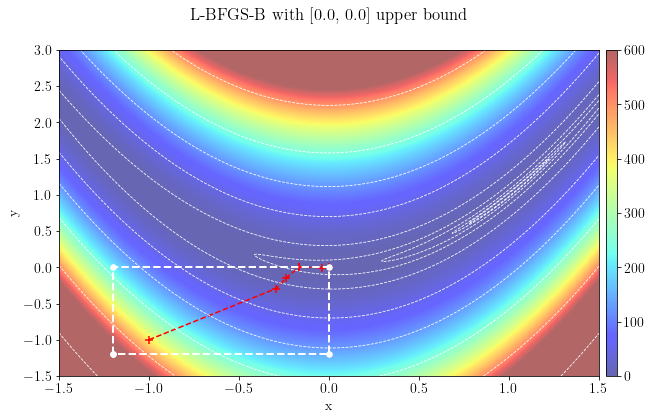

In [20]:
fig, ax = plt.subplots()

ax.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
ax.plot(x_smpld, y_smpld, "--", color='red')

ax.scatter(bounds_points_x, bounds_points_y, marker="o", color='w', s=30)
ax.plot(bounds_points_x, bounds_points_y, "--", color='w', linewidth=2)

im = ax.imshow(obj_ros.plot().T, alpha=0.6, clim=(0,600), extent=[1.5,-1.5,-1.5,3.0])
ax.set_xlabel("x"), ax.set_ylabel("y")
ax.invert_xaxis()

cs = plt.contour(obj_ros.plot().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white", linewidths=(0.8,), linestyles='--')
divider = make_axes_locatable(ax)
plt.colorbar(im, cax=divider.append_axes("right", size="2%", pad=0.1))
plt.suptitle(r"L-BFGS-B with %s upper bound" % maxBound[:].tolist())
plt.show()

Again, the method is able to reach the closest feasible minimum of the objective function.